In [1]:
import sys
sys.path.append('./../../')
sys.path.append('./..')
sys.path.append('./../../designer/script/')


from film import FreeFormFilm, BaseFilm, TwoMaterialFilm, EqOTFilm
from design import BaseDesign
from spectrum import BaseSpectrum, Spectrum
from optimizer.adam import AdamFreeFormOptimizer

from analyze_utils.make_design import make_edgefilter_design, make_reflection_design, make_three_line_filter_design
from utils.loss import calculate_RMS_f_spec
from analyze_utils.result_io import save, load
from analyze_utils.structure import plot_layer_thickness

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import pickle

In [15]:
# design = make_edgefilter_design()
# design = make_reflection_design(wls=np.linspace(695, 939, 500))
reps = 1

n_min = 1.5
n_max = 3

# adam optimizer parameters
alpha = 0.1
batch_size = 200

def exp(n_size, each_ot, design):
    np.random.seed()
    init_n = np.random.random(n_size) * 3 + 1
    init_film = EqOTFilm(init_n, each_ot * n_size, substrate='SiO2')

    adam_optimizer = AdamFreeFormOptimizer(
        init_film, 
        design.target_specs, 
        max_steps=200, 
        alpha=alpha, # 0.1
        record=False, 
        show=False, 
        n_min=n_min, # 1.5
        n_max=n_max, # 3
        wl_batch_size=batch_size # 200 / 500
    )

    adam_optimizer.optimize()
    return calculate_RMS_f_spec(init_film, design.target_specs), init_film



In [ ]:
each_ots = np.linspace(1, 1000, 50)
n_sizes = np.arange(1, 1001, 20)

# wl_min = 500
# wl_max = 1000 # 1 / wl_max - 1 / wl_min = 1 / 1000

design = make_three_line_filter_design() # 1 / wl_max - 1 / wl_min = 



films_arr_rep, best_loss_arr_rep, best_film_arr_rep = [], [], []
for rep in range(reps):
    films_arr_rep.append([])
    best_loss_arr_rep.append([])
    best_film_arr_rep.append([])
    for ot in each_ots:
        films_arr_rep[-1].append([])
        best_loss_arr_rep[-1].append([])
        best_film_arr_rep[-1].append([])
        for n_size in n_sizes:
            print(n_size / n_sizes[-1], ot / each_ots[-1])
            best_loss, best_film = exp(n_size, ot, design)
            films_arr_rep[-1][-1].append([])
            best_loss_arr_rep[-1][-1].append(best_loss)
            best_film_arr_rep[-1][-1].append(best_film)



In [31]:
save('./raw_result/free_form_params_ot1to1000_nsize1to1000', np.array(best_loss_arr_rep), np.array(best_film_arr_rep))

film has no spec. use 1000 nm


(<AxesSubplot: title={'center': 'refractive index distribution at  1000 nm'}, xlabel='position / nm'>,
 <Figure size 600x100 with 1 Axes>)

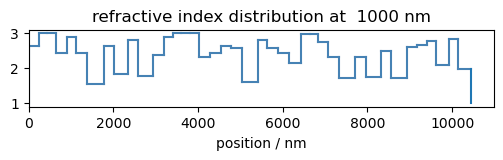

In [68]:
f = best_film_arr_rep[0][3][-1][0]
plot_layer_thickness(EqOTFilm(f.get_n()[:40], f.get_optical_thickness(100), '1'))

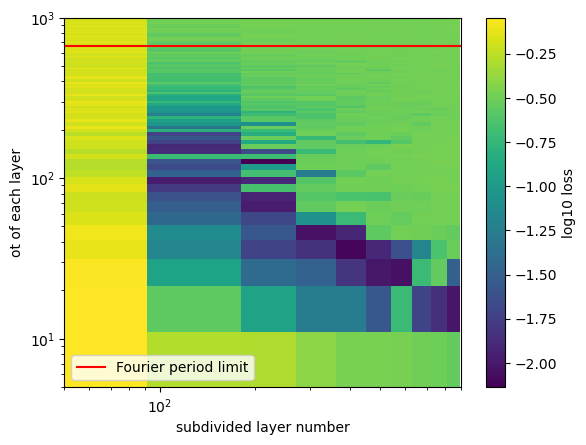

In [52]:

fig, ax = plt.subplots(1, 1)
s = ax.imshow(
    np.log10(best_loss_arr), 
    extent=[n_sizes[0], n_sizes[-1], each_ots[-1], each_ots[0]], 
    aspect='auto'
)
ax.plot([1, 901], [666, 666], c='red', label='Fourier period limit')
ax.invert_yaxis()
ax.set_ylabel('ot of each layer')
ax.set_xlabel('subdivided layer number')

ax.set_yscale('log')
ax.set_ylim(5, None)
ax.set_xscale('log')
ax.set_xlim(50, None)


ax.legend()


cbar = fig.colorbar(s)
cbar.set_label('log10 loss')

# fig.savefig('./results/design/Fourier/scan_ot_and_layernumber_log.png', dpi=300)